# Car Price prediction
Предсказание стоимости автомобиля на разных типах данных с использованием различных моделей машинного обучения и нейросетей



__Работа с изображениями:__
* Предобработка
* Аугментация

Построим три сети для обработки каждого типа данных без головы

Применим голову с Multiple Inputs для объединения трех сетей в одну

In [1]:
!pip install -q tensorflow==2.3

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
#аугментации изображений
!pip install albumentations -q

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [3]:
!pip install pymystem3

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


# Импортируем библиотеки

In [4]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

# For NLP
import nltk
from nltk.probability import FreqDist
from nltk import word_tokenize
from nltk.corpus import stopwords
#from pymystem3 import Mystem
from string import punctuation
import re

# For ML
# from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import f_classif


# Keras
import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import albumentations


# Charts
import PIL
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
%matplotlib inline
# Увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 12, 6

# Функции

In [5]:
#метрика МАРЕ
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [6]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [ ]:
!pip freeze > requirements.txt

# DATA

In [7]:
DATA_DIR = '../input/sf-dst-car-price-prediction-part2/'
train = pd.read_csv(DATA_DIR + 'train.csv')
test = pd.read_csv(DATA_DIR + 'test.csv')
sample_submission = pd.read_csv(DATA_DIR + 'sample_submission.csv')
#загружаем уже предобработанный  датасет
data = pd.read_csv('../input/mydata/data.csv')

In [8]:
data.head(2)

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,numberOfDoors,productionDate,sell_id,vehicleTransmission,Владельцы,ПТС,Привод,sample,price,mileage_prod_date,mileage_owns,owns_year
0,универсал 5 дв.,MERCEDES,чёрный,эксклюзивный проект 124 универсал 300te 24 spo...,3,220,бензин,350000,1984,W124,5,1991,1099427284,автоматическая,3,Оригинал,задний,0,0.0,175,116666,12
1,купе,BMW,белый,любимый тачил обвес тюнинг hamman ездить долж...,3,313,дизель,15000,2011,6ER,2,2013,1096405886,автоматическая,1,Оригинал,полный,0,0.0,7,15000,10


In [9]:
# Категориальные признаки
categorical_features = [
    'bodyType',
    'brand',
    'color',
    'fuelType',
    'model_info',
    'numberOfDoors',
    'vehicleTransmission',
    'Владельцы',
    'ПТС',
    'Привод'
]

# Числовые признаки
numerical_features = [
    'engineDisplacement',
    'mileage',
    'modelDate',
    'mileage_prod_date',
    'mileage_owns',
    'owns_year',
    'productionDate',
    'enginePower'
]

# PreProc Tabular Data

In [10]:
def preproc_data(df_input):

    df_output = df_input.copy()

    # убираем не нужные для модели признаки
    df_output.drop(['description', 'sell_id'], axis=1, inplace=True)

    # Логарифмирование
    for col in numerical_features:
        df_output[col] = np.log(df_output[col] + 1)
        #логарифмируем и таргет тоже
    # df_output['price'] = np.log(df_output['price'] + 1)

    # Нормализация данных
    scaler = MinMaxScaler()
    for column in numerical_features:
        df_output[column] = scaler.fit_transform(df_output[[column]])[:, 0]

    # Label Encoding
    for column in categorical_features:
        df_output[column] = df_output[column].astype('category').cat.codes

    # One-Hot Encoding: в pandas есть готовая функция - get_dummies.
    df_output = pd.get_dummies(
        df_output, columns=categorical_features, dummy_na=False)

    return df_output

In [11]:
# Запускаем и проверяем, что получилось
df_preproc = preproc_data(data)
df_preproc.sample(10)

,engineDisplacement,enginePower,mileage,modelDate,productionDate,sample,price,mileage_prod_date,mileage_owns,owns_year,bodyType_0,bodyType_1,bodyType_2,bodyType_3,bodyType_4,bodyType_5,bodyType_6,bodyType_7,bodyType_8,bodyType_9,bodyType_10,bodyType_11,bodyType_12,bodyType_13,bodyType_14,bodyType_15,bodyType_16,brand_0,brand_1,brand_2,color_0,color_1,color_2,color_3,color_4,color_5,color_6,color_7,color_8,color_9,color_10,color_11,color_12,color_13,color_14,color_15,fuelType_0,fuelType_1,fuelType_2,fuelType_3,model_info_0,model_info_1,model_info_2,model_info_3,model_info_4,model_info_5,model_info_6,model_info_7,model_info_8,model_info_9,model_info_10,model_info_11,model_info_12,model_info_13,model_info_14,model_info_15,model_info_16,model_info_17,model_info_18,model_info_19,model_info_20,model_info_21,model_info_22,model_info_23,model_info_24,model_info_25,model_info_26,model_info_27,model_info_28,model_info_29,model_info_30,model_info_31,model_info_32,model_info_33,model_info_34,model_info_35,model_info_36,model_info_37,model_info_38,model_info_39,model_info_40,model_info_41,model_info_42,model_info_43,model_info_44,model_info_45,model_info_46,model_info_47,model_info_48,model_info_49,model_info_50,model_info_51,model_info_52,model_info_53,model_info_54,model_info_55,model_info_56,model_info_57,model_info_58,model_info_59,model_info_60,model_info_61,model_info_62,model_info_63,model_info_64,model_info_65,model_info_66,model_info_67,model_info_68,model_info_69,model_info_70,model_info_71,model_info_72,model_info_73,model_info_74,model_info_75,model_info_76,model_info_77,model_info_78,model_info_79,model_info_80,model_info_81,model_info_82,model_info_83,model_info_84,model_info_85,model_info_86,model_info_87,model_info_88,model_info_89,model_info_90,model_info_91,model_info_92,model_info_93,model_info_94,model_info_95,model_info_96,model_info_97,model_info_98,model_info_99,model_info_100,model_info_101,model_info_102,model_info_103,model_info_104,model_info_105,model_info_106,model_info_107,model_info_108,model_info_109,model_info_110,model_info_111,model_info_112,model_info_113,model_info_114,model_info_115,model_info_116,model_info_117,model_info_118,model_info_119,model_info_120,model_info_121,numberOfDoors_0,numberOfDoors_1,numberOfDoors_2,numberOfDoors_3,vehicleTransmission_0,vehicleTransmission_1,vehicleTransmission_2,vehicleTransmission_3,Владельцы_0,Владельцы_1,Владельцы_2,ПТС_0,ПТС_1,Привод_0,Привод_1,Привод_2
7399,0.564575,0.528676,0.829686,0.896948,0.869500,1,1590000.0,0.641460,0.829686,0.428043,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,1,0,0,1
4273,0.564575,0.528676,0.763680,0.876307,0.895626,1,3100000.0,0.504212,0.763680,0.464411,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,1,0,0,1
3362,0.920782,0.919349,0.778972,0.876307,0.869500,1,3750000.0,0.535845,0.695253,0.125195,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,1,0,0,1
2794,0.712414,0.528676,0.841535,0.834995,0.764868,1,1990000.0,0.666249,0.757815,0.214022,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,

In [ ]:
df_preproc.info()

## Split data

In [12]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.price.values     # наш таргет
X = train_data.drop(['price'], axis=1)
X_sub = test_data.drop(['price'], axis=1) # на этой части будем тестировать

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

## Model 5: Добавляем картинки

### Подготовка данных для CV

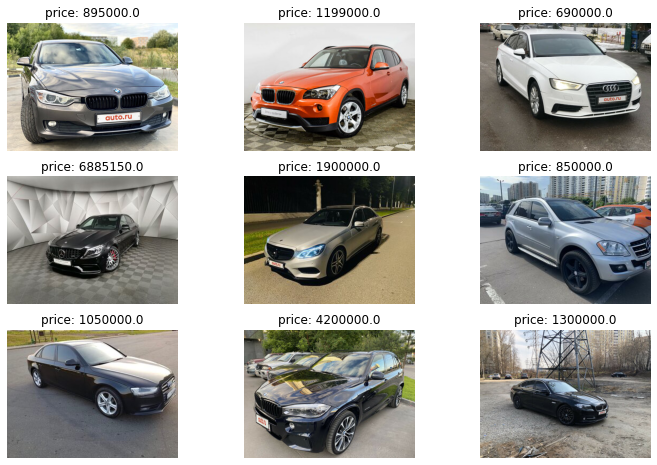

In [14]:
# убедимся, что цены и фото подгрузились верно
plt.figure(figsize = (12,8))

random_image = train.sample(n = 9)
random_image_paths = random_image['sell_id'].values
random_image_cat = random_image['price'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(DATA_DIR+'img/img/' + str(path) + '.jpg')
    plt.subplot(3, 3, index + 1)
    plt.imshow(im)
    plt.title('price: ' + str(random_image_cat[index]))
    plt.axis('off')
plt.show()

In [15]:
size = (320, 240)

def get_image_array(index):
    images_train = []
    for index, sell_id in enumerate(data['sell_id'].iloc[index].values):
        image = cv2.imread(DATA_DIR + 'img/img/' + str(sell_id) + '.jpg')
        assert(image is not None)
        image = cv2.resize(image, size)
        images_train.append(image)
    images_train = np.array(images_train)
    print('images shape', images_train.shape, 'dtype', images_train.dtype)
    return(images_train)

images_train = get_image_array(X_train.index)
images_test = get_image_array(X_test.index)
images_sub = get_image_array(X_sub.index)

images shape (5679, 240, 320, 3) dtype uint8
images shape (1003, 240, 320, 3) dtype uint8
images shape (1671, 240, 320, 3) dtype uint8


#### Аугментация

In [16]:
augmentation = albumentations.Compose([
    albumentations.HorizontalFlip(p=0.5),
    albumentations.Rotate(limit=10, interpolation=1, border_mode=4,
                          always_apply=False, p=0.8),
    albumentations.OneOf([
        albumentations.RandomBrightnessContrast(
            brightness_limit=0.3, contrast_limit=0.3),
        albumentations.RandomBrightnessContrast(
            brightness_limit=0.2, contrast_limit=0.2),
        albumentations.RandomBrightnessContrast(
            brightness_limit=0.1, contrast_limit=0.1)
    ], p=0.7),
    albumentations.Blur(blur_limit=3, always_apply=False, p=0.5),
    albumentations.HueSaturationValue(
        hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, always_apply=False, p=0.7),
    albumentations.RGBShift(r_shift_limit=20, g_shift_limit=20,
                            b_shift_limit=20, always_apply=False, p=0.7),
    albumentations.ChannelShuffle(p=0.7),
    albumentations.CLAHE(clip_limit=3.0, tile_grid_size=(
        8, 8), always_apply=False, p=0.3)
])

посмотрим, что получилось

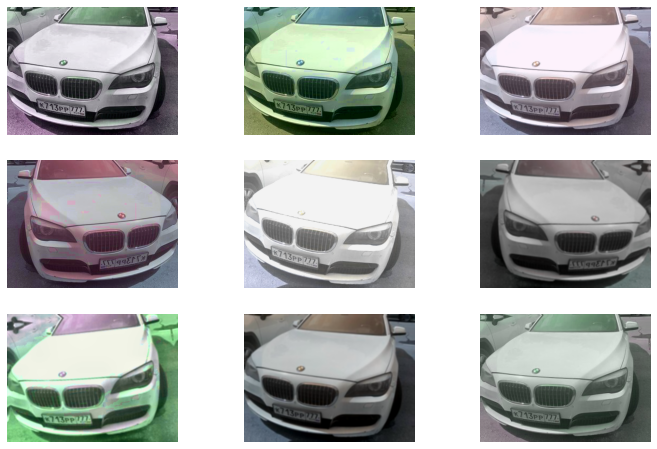

In [17]:
plt.figure(figsize=(12, 8))
for i in range(9):
    img = augmentation(image=images_train[0])['image']
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [19]:
def make_augmentations(images):
    print('применение аугментаций', end='')
    augmented_images = np.empty(images.shape)
    for i in range(images.shape[0]):
        if i % 200 == 0:
            print('.', end='')
        augment_dict = augmentation(image=images[i])
        augmented_image = augment_dict['image']
        augmented_images[i] = augmented_image
    print('')
    return augmented_images

### подготовка данных для NLP

In [20]:
# TOKENIZER
# The maximum number of words to be used. (most frequent)
MAX_WORDS = 100000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 256

In [21]:
# split данных
text_train = data.description.iloc[X_train.index]
text_test = data.description.iloc[X_test.index]
text_sub = data.description.iloc[X_sub.index]

#### Tokenizer

In [22]:
%%time
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(data.description)

CPU times: user 1.08 s, sys: 565 µs, total: 1.08 s
Wall time: 1.08 s


### Подготовка всех данных для модели

In [23]:
def process_image(image):
    return augmentation(image = image.numpy())['image']

def tokenize_(descriptions):
    return sequence.pad_sequences(tokenize.texts_to_sequences(descriptions), maxlen = MAX_SEQUENCE_LENGTH)

def tokenize_text(text):
    return tokenize_([text.numpy().decode('utf-8')])[0]

def tf_process_train_dataset_element(image, table_data, text, price):
    im_shape = image.shape
    [image,] = tf.py_function(process_image, [image], [tf.uint8])
    image.set_shape(im_shape)
    [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price

def tf_process_val_dataset_element(image, table_data, text, price):
    [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price

train_dataset = tf.data.Dataset.from_tensor_slices((
    images_train, X_train, data.description.iloc[X_train.index], y_train
    )).map(tf_process_train_dataset_element)

test_dataset = tf.data.Dataset.from_tensor_slices((
    images_test, X_test, data.description.iloc[X_test.index], y_test
    )).map(tf_process_val_dataset_element)

y_sub = np.zeros(len(X_sub))
sub_dataset = tf.data.Dataset.from_tensor_slices((
    images_sub, X_sub, data.description.iloc[X_sub.index], y_sub
    )).map(tf_process_val_dataset_element)

#проверяем, что нет ошибок (не будет выброшено исключение):
train_dataset.__iter__().__next__();
test_dataset.__iter__().__next__();
sub_dataset.__iter__().__next__();

### Строим сверточную сеть для анализа изображений без "головы"

In [24]:
# нормализация включена в состав модели EfficientNetB3, поэтому на вход она принимает данные типа uint8
efficientnet_model = tf.keras.applications.efficientnet.EfficientNetB3(
    weights='imagenet', include_top=False, input_shape=(size[1], size[0], 3))
efficientnet_output = L.GlobalAveragePooling2D()(efficientnet_model.output)

43941888/43941136 [==============================] - 1s 0us/step


### Строим сверточную сеть для табличных данных без "головы"

In [25]:
tabular_model = Sequential([
    L.Input(shape=X.shape[1]),
    L.Dense(512, activation='relu'),
    L.Dropout(0.5),
    L.Dense(256, activation='relu'),
    L.Dropout(0.25),
])

### NLP-нейросеть для текстовых данных без "головы"

In [26]:
# NLP
nlp_model = Sequential([
    L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"),
    L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,),
    L.LSTM(256, return_sequences=True),
    L.Dropout(0.5),
    L.LSTM(128),
    L.Dropout(0.25),
    L.Dense(64),
])

### Multiple Inputs "голова"

In [27]:
# объединяем выходы трех нейросетей
combinedInput = L.concatenate(
    [efficientnet_output, tabular_model.output, nlp_model.output])

# being our regression head
head = L.Dense(256, activation="relu")(combinedInput)
head = L.Dense(1,)(head)

model = Model(inputs=[efficientnet_model.input,
                      tabular_model.input, nlp_model.input], outputs=head)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 240, 320, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 240, 320, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 240, 320, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 241, 321, 3)  0           normalization[0][0]              
_______________________________________________________________________________________

### Fit

In [46]:
#добавляю политику на LR
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.005,
    decay_steps=10000,
    decay_rate=0.9)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
#optimizer = tf.keras.optimizers.Adam(0.005)

#компилирую модель
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [40]:
#добавим еще один коллбек
#если использовать ExponentialDecay для LR, то с коллбэком для ReduceLROnPlateau не совместимо
#https://github.com/tensorflow/tensorflow/issues/36612
#reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
                            #monitor = 'val_loss', 
                            #factor = 0.5, 
                            #patience = 2, 
                            #min_lr=0.00000001,
                            #verbose=1,
                            #mode='min')

checkpoint = ModelCheckpoint('../working/best_img_model.hdf5', monitor=['val_MAPE'], verbose=0, mode='min')

earlystop = EarlyStopping(monitor='val_MAE', patience=4, restore_best_weights=True,)

#callbacks_list = [reduce_lr, checkpoint, earlystop]
callbacks_list = [checkpoint, earlystop]

In [48]:
history = model.fit(train_dataset.batch(5),
                    epochs=10,
                    validation_data = test_dataset.batch(5),
                    callbacks=callbacks_list
                   )

Epoch 1/10
1136/1136 [==============================] - 226s 199ms/step - loss: 13.5396 - MAPE: 13.5396 - val_loss: 12.7333 - val_MAPE: 12.7333
Epoch 2/10
1136/1136 [==============================] - 219s 193ms/step - loss: 13.8841 - MAPE: 13.8841 - val_loss: 12.9934 - val_MAPE: 12.9934
Epoch 3/10
1136/1136 [==============================] - 216s 191ms/step - loss: 13.7567 - MAPE: 13.7567 - val_loss: 12.9693 - val_MAPE: 12.9693
Epoch 4/10
1136/1136 [==============================] - 216s 190ms/step - loss: 13.8127 - MAPE: 13.8127 - val_loss: 12.9388 - val_MAPE: 12.9388
Epoch 5/10
1136/1136 [==============================] - 218s 192ms/step - loss: 13.7485 - MAPE: 13.7485 - val_loss: 13.3824 - val_MAPE: 13.3824
Epoch 6/10
1136/1136 [==============================] - 221s 194ms/step - loss: 13.8002 - MAPE: 13.8002 - val_loss: 13.8660 - val_MAPE: 13.8660
Epoch 7/10
1136/1136 [==============================] - 221s 194ms/step - loss: 13.5689 - MAPE: 13.5689 - val_loss: 13.5007 - val_MAPE: 

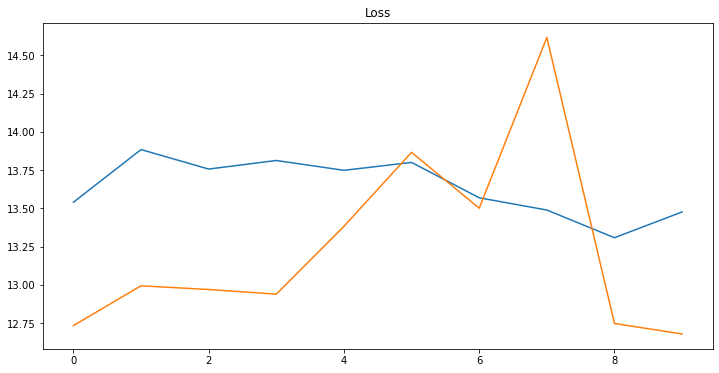

In [49]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [50]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_mlp_nlp.hdf5')

In [51]:
test_predict_nn4 = model.predict(test_dataset.batch(35))
print(f"TEST mape: {(mape(y_test, test_predict_nn4[:,0]))*100:0.2f}%")

TEST mape: 12.68%


In [52]:
sub_predict_nn4 = model.predict(sub_dataset.batch(35))
sample_submission['price'] = sub_predict_nn4[:, 0]
sample_submission.to_csv('nn4_submission.csv', index=False)

## Вывод по  части 4:
* Построена СV модель для обработки изображений. 
* Данные СV модели, NLP модели и NN модели объеденены в multiple inputs сеть.
* С помощью обработки изображений удалось улучшить метрику по сравнению с бэйзлайном
* Достигнут показатель МАРЕ: 13.15%